# Proyecto 04 - Sistemas de Recomendación Steam y analisis NLP

## Dataset: STEAM

Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.

**Se parte de lo antes resuelto en el proyecto anterior, creando un dataset nuevo y combinando ambos , viendo si la columna 'text' puede llegar a mejorar las predicciones.**

## **IMPORTANTE:** 
#### por cuestiones de implementacion y para poder comparar correctamente los modelos, se cambio el rating siendo antes de 1 a 10, ahora se tomo como punto de martida la mediana que es el valor mas representativo de las horas y si los juegos superan esa medida significa que les gusto y de lo contrario no.

**Asi podremos ver si realmente la implementacion de NLP fue beneficiosa o no.**

**Por razones antes mencionadas, se vuelve a hacer el mismo analisis que en el proyecto anterior con el nuevo rating y luego se continua con las nuevas predicciones**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import gzip
from matplotlib import rcParams
from scipy.stats import norm
import gc #garbage collector
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import SVD
sns.set(palette="Blues_d")

import warnings
warnings.filterwarnings('ignore')

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1 

### Reviews dataframe

In [4]:
data_reviews = pd.DataFrame(data_reviews)

#evitamos que los product_id aparezcan con notación cientrífica
pd.options.display.float_format = '{:.1f}'.format
#borramos duplicados
data_reviews.drop_duplicates(subset=['product_id', 'user_id'], keep='last')

data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,nan
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,nan
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,nan
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,nan
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,nan


In [5]:
#creo una copia para utilizar en la investigacion del ultimo punto
datain = data_reviews

### Games dataframe

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [7]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.5,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],5.0,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",nan,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",nan,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.8,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],1.0,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.8,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",3.0,False,773570,NaN,NaN,NaN


# EXPLORACIÓN DE DATOS - Analisis Exploratorio de Datos
# Data Reviews 

*Las siguientes son las explicaciones de lo que aparece en cada columna del dataset:

**Username**: Nombre del usuario.

**hours**: Cantidad de horas jugadas (acumuladas).

**products**: Cantidad de juegos probados.

**product_id**: Identificacion númerica del juego.

**page_order**: Número de página en el cual se encuentra el juego dentro de la plataforma.

**date**: Fecha de la reseña.

**text**: Comentario.

**early_access**: Si se compro en la etapa de desarrollo.

**page**: ??

**user_id**: Identificación numérica del usuario.

**found_funny**: Cantidad de calificaciones positivas creadas por otros usuarios.

**compensation**: ??

In [8]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

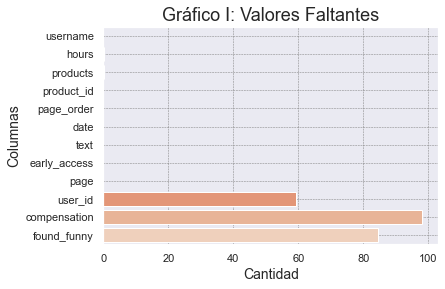

,Total,Percent
compensation,764719,98.1
found_funny,659143,84.6
user_id,461967,59.3
hours,2637,0.3
products,1566,0.2


In [9]:
#Valores faltantes
missing=data_reviews.isna().sum()/len(data_reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=data_reviews.columns
##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico I: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()
def missing_percentage(df):
    total = data_reviews.isnull().sum().sort_values(ascending = False)[data_reviews.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(data_reviews.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(data_reviews.isnull().sum().sort_values(ascending = False)/len(data_reviews)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(data_reviews)

Voy a descartar las dos columnas con mayores datos faltantes (Compensation y found_funny) ademas eliminare page_order ya que no brinda informacion que crea significativa

In [10]:
#tomo las columnas relevantes
data_reviews=data_reviews[['user_id','username','product_id','text','hours','products','date','page','early_access']]

#se eliminan los valores faltantes
data_reviews.dropna(subset=['username'], how='all', inplace=True)
data_reviews.dropna(subset=['text'], how='all', inplace=True)
data_reviews.dropna(subset=['hours'], how='all', inplace=True)
data_reviews.dropna(subset=['products'], how='all', inplace=True)

#tipo de datos
data_reviews.dtypes

user_id          object
username         object
product_id       object
text             object
hours           float64
products        float64
date             object
page              int64
early_access       bool
dtype: object

### Analizaremos las horas jugadas por review

In [11]:
data_reviews.hours.describe().round()

count   775105.0
mean       112.0
std        390.0
min          0.0
25%          4.0
50%         15.0
75%         60.0
max      28164.0
Name: hours, dtype: float64

Se puede ver la presencia de posibles outliers ya que tenemos una media de 112 horas con una maxima de 28164 horas por lo que a continuacion lo trataremos en el grafico para poder analizarlo.

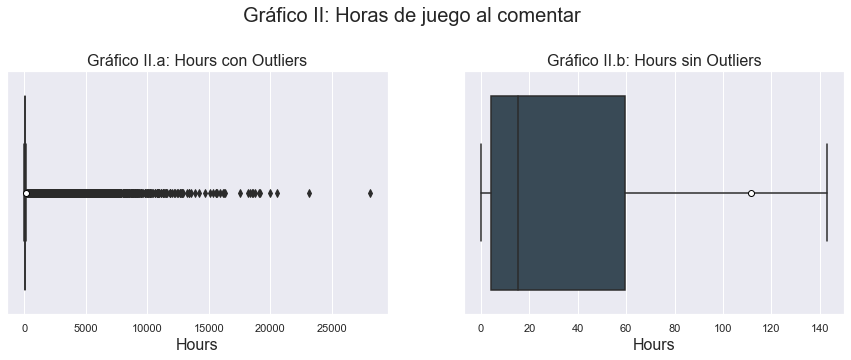

In [12]:
#Boxplot Hours
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico II: Horas de juego al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = data_reviews,x='hours',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
sns.boxplot(data = data_reviews,x='hours',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico II.a: Hours con Outliers",fontsize=16)
ax2.set_title("Gráfico II.b: Hours sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

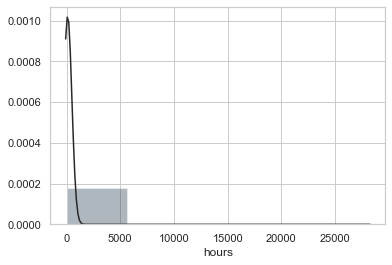

In [13]:
sns.set_style("whitegrid")
x = data_reviews.hours
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

En el grafico anterior podemos ver que hay una marcada cola hacia la derecha por lo que deberiamos utilizar la mediana para ser mas representativos con respecto a los datos de las horas jugadas, el cual es 15 horas.

Para saber si es util eliminarlos o no, cuantificaremos esos posibles outliers para ver si son utiles en cuanto a nuestro analisis.

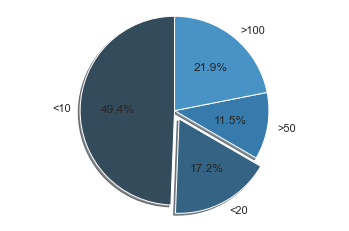

In [14]:
menorQue10=len(data_reviews[data_reviews.hours<10])
menorQue20=len(data_reviews[(data_reviews.hours>10)&(data_reviews.hours<20)])
mayorQue50=len(data_reviews[(data_reviews.hours>50)&(data_reviews.hours<100)])
mayoresQue100=len(data_reviews[data_reviews.hours>100])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['<10', '<20', '>50', '>100']
sizes = [menorQue10, menorQue20, mayorQue50, mayoresQue100]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Creo que al descartar los valores mayores a 100 (22%) perderia mucha informacion, asi que no los tratare como outliers.

### Analizaremos a continuacion el user_id

In [15]:
print(data_reviews.user_id.nunique())
print(data_reviews.username.nunique())

260507
537742


In [16]:
print(data_reviews['user_id'].value_counts())

76561198011965365    114
76561198094803808     88
76561197969749884     70
76561198094321628     62
76561198073092169     57
                    ... 
76561198121314841      1
76561198231667584      1
76561198027780286      1
76561198308868538      1
76561197994402473      1
Name: user_id, Length: 260507, dtype: int64


In [17]:
print(data_reviews['username'].value_counts())

123                  213
Alex                 189
Chris                154
Nick                 142
Matt                 137
                    ... 
Gunner™ (G.E.W.P)      1
BIG BIRCHY             1
Shrymp                 1
pbppbp17               1
Karranao               1
Name: username, Length: 537742, dtype: int64


Hay muchos user_id que tienen varios usernames por lo que no podriamos utilizarlos directamente. Al haber tantos valores faltantes en user_id lo que podriamos hacer es generar un valor unico por cada username y asi solucionar los NaN de esta columna.

In [18]:
usuarios=data_reviews['username'].unique()
usr_unico=pd.DataFrame(usuarios,columns=['username'])   
finRango=len(usr_unico)+1
user_id=np.array(range(1,finRango,1))
usr_unico['user_id']=user_id
usr_unico

,username,user_id
0,Chaos Syren,1
1,Ariman1,2
2,freakfantom,3
3,The_Cpt_FROGGY,4
4,the_maker988,5
...,...,...
537737,Seikleja,537738
537738,KindAlcoholic,537739
537739,SepticFalcon,537740
537740,RancorZealot,537741


Voy a crear una copia del dataset para comenzar a hacerlo mas liviano y dejar solo las columnas que me van a servir luego y a su vez agregarle la columna con el id unico realizado anteriormente.

In [19]:
reviews = data_reviews

In [20]:
reviews.drop(['date', 'products','text','early_access','page', 'user_id'], axis=1, inplace=True)
reviews.head()

,username,product_id,hours
0,Chaos Syren,725280,0.1
1,Ariman1,328100,13.2
2,freakfantom,725280,0.1
3,The_Cpt_FROGGY,631920,7.8
4,the_maker988,35140,8.2


In [21]:
reviews=reviews.merge(usr_unico, left_on='username', right_on='username')
reviews

,username,product_id,hours,user_id
0,Chaos Syren,725280,0.1,1
1,Ariman1,328100,13.2,2
2,Ariman1,521230,0.5,2
3,Ariman1,493980,2.0,2
4,freakfantom,725280,0.1,3
...,...,...,...,...
775100,Seikleja,252490,80.8,537738
775101,KindAlcoholic,252490,1303.6,537739
775102,SepticFalcon,252490,334.9,537740
775103,RancorZealot,252490,203.5,537741


# Games

In [22]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

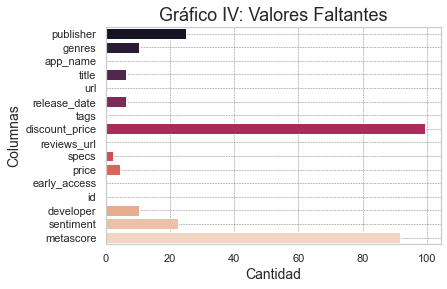

,Total,Percent
discount_price,31910,99.3
metascore,29458,91.7
publisher,8052,25.1
sentiment,7182,22.4
developer,3299,10.3
genres,3283,10.2
release_date,2067,6.4
title,2050,6.4
price,1377,4.3
specs,670,2.1


In [23]:
#Valores faltantes
missing=data_games.isna().sum()/len(data_games)*100
#se crea otra serie para usar como variable independiente.
columnas=data_games.columns

##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico IV: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()

def missing_percentage(df):
    total = data_games.isnull().sum().sort_values(ascending = False)[data_games.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(data_games.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(data_games.isnull().sum().sort_values(ascending = False)/len(data_games)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(data_games)

Seleccionare las columnas relevantes para el proyecto y las demas las descartare

In [24]:
games=data_games
games=games[['id','app_name','title','developer','publisher','sentiment','release_date','genres','specs','tags','price']]
games.head()

,id,app_name,title,developer,publisher,sentiment,release_date,genres,specs,tags,price
0,761140,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro,Kotoshiro,NaN,2018-01-04,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",5.0
1,643980,Ironbound,Ironbound,Secret Level SRL,"Making Fun, Inc.",Mostly Positive,2018-01-04,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play
2,670290,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Poolians.com,Poolians.com,Mostly Positive,2017-07-24,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play
3,767400,弹炸人2222,弹炸人2222,彼岸领域,彼岸领域,NaN,2017-12-07,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",1.0
4,773570,Log Challenge,NaN,NaN,NaN,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",3.0


Veremos cuantos juegos hay en total

In [25]:
games.shape

(32135, 11)

Podemos ver que hay 32135 juegos pero sabemos que hay dos datos faltantes en id por lo que serian 32135. A continuacion desecharemos las columnas que no usaremos y eliminaremos esos valores faltantes

In [26]:
games.drop(columns=['title','publisher','genres','release_date','tags','specs','price','developer','sentiment'], inplace=True)
games.dropna(inplace=True)

In [27]:
games.head()

,id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Por temas de prolijidad vamos a hacer que la columna del id del jugo se llame igual que en el dateset de reviws

In [28]:
games.rename(columns={'id': 'product_id'}, inplace=True)
games

,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
...,...,...
32130,773640,Colony On Mars
32131,733530,LOGistICAL: South Africa
32132,610660,Russian Roads
32133,658870,EXIT 2 - Directions


# Modelo de machine learning (Desarrollo de sistema de recomendacion)

### Seleccion de la metrica
Basado en la informacion que obtuvimos en el analisis de los datos y en la teoria sobre las distintas metricas a utilizar, primero pense que seria mejor utilizar el MAe por la variabilidad que veiamos en las horas jugadas, pero al ver que utilizaremos un ranking de esas horas, la variabilidad baja considerablemente ya que tendremos una escala nueva y por eso tomare el RMSE.

### Creacion de la columna Rating

In [29]:
#creo el rating
#mapeo
grouped=reviews.groupby('user_id').median().sort_values(('hours'),ascending=False).head(20)

#reorganizacion de columnas
encod_type = reviews.groupby('user_id')['hours'].median()
reviews.loc[:, 'median_hours'] = reviews['user_id'].map(encod_type)

reviews.dropna(subset=['user_id'], how='all', inplace=True)
reviews['rating'] = np.where(reviews['hours']>=reviews['median_hours'], 1, 0)
reviews['rating'] = reviews['rating'].astype(np.uint8)
reviews = reviews.reset_index(drop=True)

In [30]:
reviews.head()

,username,product_id,hours,user_id,median_hours,rating
0,Chaos Syren,725280,0.1,1,0.1,1
1,Ariman1,328100,13.2,2,2.0,1
2,Ariman1,521230,0.5,2,2.0,0
3,Ariman1,493980,2.0,2,2.0,1
4,freakfantom,725280,0.1,3,0.1,1


Hour no sera mas de utilidad por lo que la eliminare

In [31]:
reviews.drop(columns=['hours'], inplace=True)

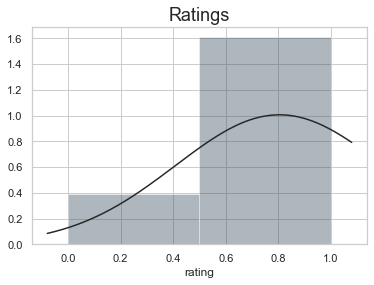

In [32]:
sns.set_style("whitegrid")
x = reviews.rating
plt.title("Ratings",fontsize=18)
ax = sns.distplot(x, fit=norm, kde=False, bins=2)

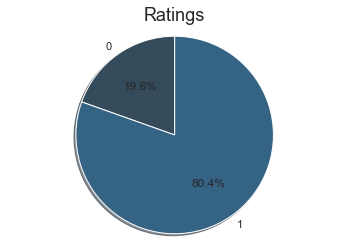

In [33]:
r0=len(reviews[reviews.rating==0])
r1=len(reviews[reviews.rating==1])

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [0,1]
sizes = [r0,r1]
explode = (0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
plt.title("Ratings",fontsize=18)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Lo que note a lo largo que desarrollaba el proyecto era que habia usuarios que habian realizado varios reviews sobre el mismo juego por lo que tenia en rating varias puntuaciones diferentes o iguales. Lo que hare es contar esas instancias duplicadas y tomar la ultima ya que sera la puntuacion definitiva (por las horas que ya tiene jugadas).

In [34]:
len(reviews)-len(reviews.drop_duplicates())

9884

In [35]:
reviews.drop_duplicates(subset=['product_id', 'user_id'], keep='last', inplace=True)
reviews

,username,product_id,user_id,median_hours,rating
0,Chaos Syren,725280,1,0.1,1
1,Ariman1,328100,2,2.0,1
2,Ariman1,521230,2,2.0,0
3,Ariman1,493980,2,2.0,1
4,freakfantom,725280,3,0.1,1
...,...,...,...,...,...
775100,Seikleja,252490,537738,80.8,1
775101,KindAlcoholic,252490,537739,1303.6,1
775102,SepticFalcon,252490,537740,334.9,1
775103,RancorZealot,252490,537741,203.5,1


Para mejorar nuestra prediccion sacaremos todos los usuarios que tengan 3 rankeos o menos

In [36]:
filtro=reviews[['user_id','product_id','rating']].groupby(by='user_id').count()
filtro.head()

,product_id,rating
user_id,,
1,1,1
2,3,3
3,1,1
4,27,27
5,1,1


20666


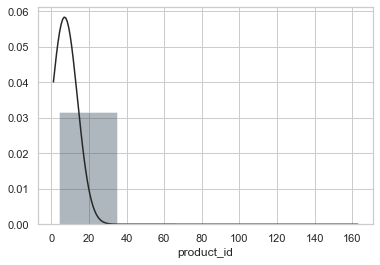

In [37]:
filtro=filtro[(filtro.product_id>3) ]
print(len(filtro))
sns.set_style("whitegrid")
x = filtro.product_id
ax = sns.distplot(x, fit=norm, kde=False, bins=5)

In [38]:
filtro_usuarios=pd.DataFrame(filtro)

In [39]:
filtro= filtro.rename_axis('user_id').reset_index()

In [40]:
grupo_usuarios=filtro['user_id'].values
reviews=reviews[reviews.user_id.isin(grupo_usuarios) ]
reviews

,username,product_id,user_id,median_hours,rating
5,The_Cpt_FROGGY,631920,4,6.8,1
6,The_Cpt_FROGGY,482440,4,6.8,1
7,The_Cpt_FROGGY,736860,4,6.8,0
8,The_Cpt_FROGGY,493540,4,6.8,1
9,The_Cpt_FROGGY,341980,4,6.8,0
...,...,...,...,...,...
695627,Podel,12120,461385,20.4,0
705565,WinnB,563560,470697,13.1,0
705566,WinnB,427520,470697,13.1,1
705567,WinnB,290530,470697,13.1,0


### Benchmark - SVD

Modificamos la escala para surprise ya que por defecto es de 0 a 5

In [41]:
reader = Reader(rating_scale=(0, 1))

Creamos el dataset que utilizaremos para la prediccion

In [42]:
data=reviews[['user_id','product_id','rating']]
data.head()

,user_id,product_id,rating
5,4,631920,1
6,4,482440,1
7,4,736860,0
8,4,493540,1
9,4,341980,0


In [43]:
data = Dataset.load_from_df(data[['user_id', 'product_id', 'rating']], reader)

In [44]:
data

Separamos el dataset en train test

In [45]:
trainset, testset = train_test_split(data, test_size=.25)

### Entrenamiento

In [46]:
algo = SVD()

In [47]:
algo.fit(trainset)

In [48]:
predictions = algo.test(testset)

In [49]:
predictions[1]

Prediction(uid=315779, iid='242050', r_ui=1.0, est=0.7526047557261409, details={'was_impossible': False})

### Testeo

In [50]:
#estimamos para un usuario y un juego
#algo.predict(76561198011965359,440)
algo.predict(45948,268500)

Prediction(uid=45948, iid=268500, r_ui=None, est=0.525158259418476, details={'was_impossible': False})

.

##### Juegos que le gustaron al usuario

In [51]:
usuario = 2889
rating = 1
# Filtramos data_reviews
df_user = reviews[(reviews['user_id'] == usuario) & (reviews['rating'] == rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=games, left_on='product_id', right_on='product_id')
# Listamos el resultado
print(df_user.shape)
df_user.head()

(22, 6)


,username,product_id,user_id,median_hours,rating,app_name
0,123,445220,2889,118.4,1,Avorion
1,123,220200,2889,118.4,1,Kerbal Space Program
2,123,242680,2889,118.4,1,Nuclear Throne
3,123,262060,2889,118.4,1,Darkest Dungeon®
4,123,333930,2889,118.4,1,Dirty Bomb®


.

##### Juegos que no le gustaron al usuario

In [52]:
usuario = 2889
rating = 0
# Filtramos data_reviews
df_user = reviews[(reviews['user_id'] == usuario) & (reviews['rating'] == rating)]
#Reseteamos elindex
df_user = df_user.reset_index(drop=True)
# hacemos unjoin df_users y data_games
df_user = pd.merge(left=df_user,right=games, left_on='product_id', right_on='product_id')
# Listamos el resultado
print(df_user.shape)
df_user.head()

(89, 6)


,username,product_id,user_id,median_hours,rating,app_name
0,123,35720,2889,118.4,0,Trine 2: Complete Story
1,123,271590,2889,118.4,0,Grand Theft Auto V
2,123,337000,2889,118.4,0,Deus Ex: Mankind Divided
3,123,389730,2889,118.4,0,TEKKEN 7
4,123,307780,2889,118.4,0,Mortal Kombat X


.

##### Juegos que ya probo e hizo su review

In [53]:
usuario_jugado = reviews[reviews['user_id'] == usuario]
print(usuario_jugado.shape)
usuario_jugado.head()

(111, 5)


,username,product_id,user_id,median_hours,rating
12508,123,35720,2889,118.4,0
12509,123,271590,2889,118.4,0
12510,123,337000,2889,118.4,0
12511,123,389730,2889,118.4,0
12512,123,307780,2889,118.4,0


Crearemos un dataset donde se guardaran las recomendaciones, para ello borraremos los juegos que ya hizo su review

In [54]:
recomendaciones_usuario = games.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32132, 1)


,app_name
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,Log Challenge


In [55]:
recomendaciones_usuario.drop(usuario_jugado.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32021, 2)


,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Recomendamos

In [56]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [57]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario

,product_id,app_name,Estimate_Score
22784,394360,Hearts of Iron IV,0.7
5123,367500,Dragon's Dogma: Dark Arisen,0.7
6634,294100,RimWorld,0.7
2635,240760,Wasteland 2: Director's Cut,0.6
19588,429660,Tales of Berseria™,0.6
...,...,...,...
28518,265790,Residue: Final Cut,0.0
28524,293540,Guns and Robots,0.0
28527,307010,Northmark: Hour of the Wolf,0.0
28530,296470,Mount Your Friends,0.0


### Evaluacion

Como ya dijimos utilizaremos el RMSE asi que lo calculamos

In [58]:
accuracy.rmse(predictions)

RMSE: 0.4821


0.48212015335902375

### Optimizacion de parametros

In [59]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,5,15,25,30]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4757  0.4769  0.4769  0.4765  0.0006  
Fit time          1.45    1.23    1.26    1.31    0.09    
Test time         0.29    0.25    0.37    0.31    0.05    

Número de Factores: 5
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4769  0.4782  0.4760  0.4771  0.0009  
Fit time          1.41    1.39    1.42    1.41    0.01    
Test time         0.39    0.39    0.26    0.35    0.06    

Número de Factores: 15
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4766  0.4792  0.4767  0.4775  0.0012  
Fit time          2.02    1.79    2.22    2.01    0.18    
Test time         0.27    0.29    0.28    0.28    0.01    

Número de Factores: 25
Evaluating RMSE of algorithm SVD on 3 split(s).

  

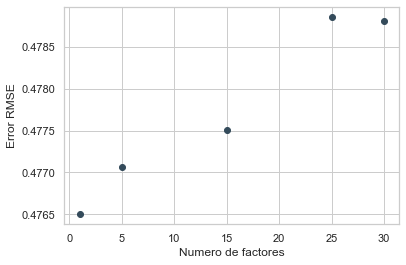

In [60]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [61]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   52.6s


Wall time: 1min 23s


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


In [62]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.4700180227546933
{'n_factors': 5, 'n_epochs': 25, 'lr_all': 0.0015, 'reg_all': 0.015}


### SVD++

In [63]:
%%time

from surprise import SVDpp
algo_pp = SVDpp()
algo_pp.fit(trainset)

predictions_pp = algo_pp.test(testset)

#Probamos
algo_pp.predict(45948,268500)

Wall time: 24.5 s


Prediction(uid=45948, iid=268500, r_ui=None, est=0.525158259418476, details={'was_impossible': False})

In [64]:
accuracy.rmse(predictions_pp)

RMSE: 0.4820


0.48198342423985135

In [65]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVDpp(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4819  0.4817  0.4825  0.4820  0.0004  
Fit time          12.48   11.79   11.93   12.07   0.30    
Test time         0.97    0.87    0.82    0.89    0.06    

Número de Factores: 2
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4814  0.4821  0.4811  0.4815  0.0004  
Fit time          12.89   12.79   13.00   12.90   0.09    
Test time         1.07    0.97    1.10    1.05    0.06    

Número de Factores: 4
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4825  0.4815  0.4820  0.4820  0.0004  
Fit time          13.12   13.16   13.97   13.42   0.39    
Test time         0.90    0.91    1.09    0.97    0.09    


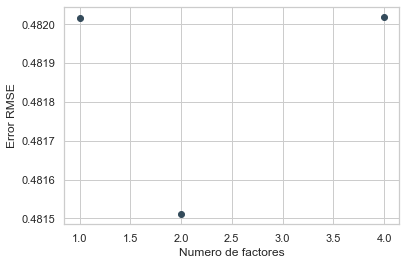

In [66]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [67]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[2],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.1min


0.4697526406409639
{'n_factors': 1, 'n_epochs': 25, 'lr_all': 0.0015, 'reg_all': 0.01}
Wall time: 10min


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 10.0min finished


## Conclusion


A partir de correr los dos modelos y optimizar hiperparámetros de cada uno de ellos podemos ver en este caso que se desempeña mejor el modelo SVD con un RMSE de 0.469 pero con un un tiempo mucho menor de ejecucion. Los hiperparámetros seleccionados son:

   * n_factors: 1,

   * n_epochs: 25

   * lr_all: 0.0015,

   * reg_all: 0.01

## PROYECTO 4 (desarrollo)

# NLP

### Se creara un dataset para ser analizado a los fines de aplicar NLP y realizar el respectivo analisis exploratorio

In [68]:
#tomo las columnas relevantes
reviews_nlp=datain[['user_id','username','product_id','text','hours']]
reviews_nlp=reviews_nlp.reset_index(drop=True)

In [69]:
#se eliminan los valores faltantes
reviews_nlp.dropna(subset=['username'], how='all', inplace=True)
reviews_nlp.dropna(subset=['text'], how='all', inplace=True)
reviews_nlp.dropna(subset=['hours'], how='all', inplace=True)

In [70]:
#creo el usuario unico
reviews_nlp=reviews_nlp.merge(usr_unico, left_on='username', right_on='username')

In [71]:
#creo el rating
#mapeo
grouped=reviews_nlp.groupby('user_id_y').median().sort_values(('hours'),ascending=False).head(20)

#reorganizacion de columnas
encod_type = reviews_nlp.groupby('user_id_y')['hours'].median()
reviews_nlp.loc[:, 'median_hours'] = reviews_nlp['user_id_y'].map(encod_type)

reviews_nlp.dropna(subset=['user_id_y'], how='all', inplace=True)
reviews_nlp['rating'] = np.where(reviews_nlp['hours']>=reviews_nlp['median_hours'], 1, 0)
reviews_nlp['rating'] = reviews_nlp['rating'].astype(np.uint8)
reviews_nlp = reviews_nlp.reset_index(drop=True)

In [72]:
del(reviews_nlp['user_id_x'])
reviews_nlp.rename(columns={'user_id_y':'user_id'},inplace=True)

In [73]:
#elimino duplicados
reviews_nlp['user_id'] = reviews_nlp['user_id'].astype(np.int64)
reviews_nlp.drop_duplicates(subset=['product_id', 'user_id'], keep='last', inplace=True)

In [74]:
#mayores a 3 reviews
reviews_nlp=reviews_nlp[reviews_nlp.user_id.isin(grupo_usuarios)]

reviews_nlp['product_id'] = reviews_nlp['product_id'].astype(np.int32)
reviews_nlp.set_index('product_id',inplace=True)

In [75]:
data_games.rename(columns={'id':'product_id'},inplace=True)
data_games['product_id'] = data_games['product_id'].astype(np.float32)
data_games.set_index('product_id',inplace=True)

In [76]:
games_nlp = data_games[['app_name','sentiment']]

In [77]:
#Combino
data_nlp=pd.merge(reviews_nlp,games_nlp, on='product_id')

In [78]:
data_nlp

,username,text,hours,user_id,median_hours,rating,app_name,sentiment
product_id,,,,,,,,
631920,The_Cpt_FROGGY,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,7.8,4,6.8,1,Somewhere on Zibylon,Positive
631920,Mia,What a cute little game! The puzzles are actua...,31.4,26,8.9,1,Somewhere on Zibylon,Positive
482440,The_Cpt_FROGGY,ESSENCE:\n~~~~~~~\nI can’t remember this place...,7.3,4,6.8,1,ESSENCE,Mostly Positive
736860,The_Cpt_FROGGY,Hidden Object Adventure: Around The World in 8...,4.7,4,6.8,0,Hidden Object Adventure: Around the World in 8...,Positive
493540,The_Cpt_FROGGY,Figment:\n~~~~~~~\n\nThe mind is one of the mo...,8.3,4,6.8,1,Figment,Very Positive
...,...,...,...,...,...,...,...,...
513370,Schatt3npakt,Blade & Bones could be so good... if it would ...,1.6,380330,2.2,0,Blade & Bones,Mixed
352740,Quicksilver,This review is coming from someone that really...,18.6,391666,28.8,0,Princess Battles,Mixed
422540,Weirdo,This film comes recommended from the gentlemen...,2.1,401292,35.4,0,Dangerous Men,9 user reviews


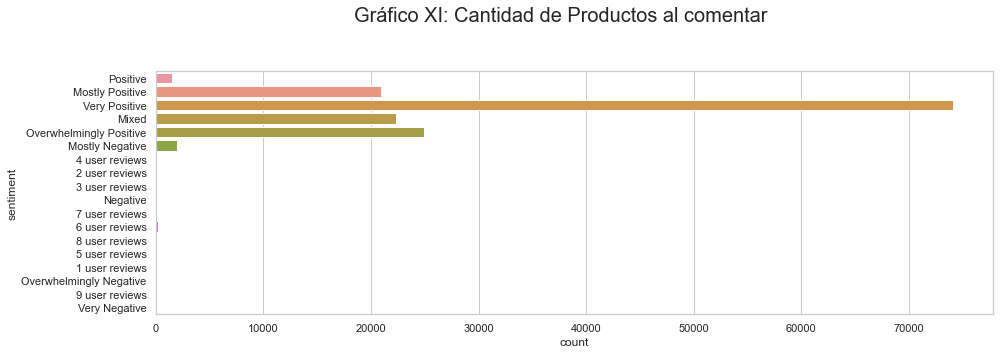

In [79]:
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XI: Cantidad de Productos al comentar',fontsize=20, ha='center')
sns.countplot(y=data_nlp.sentiment)
fig.subplots_adjust(top=0.8)
plt.show()

Podemos ver aqui el desbalanceo que hay en cuanto a los datos que hay en la columna sentiments ya que hay demasiados comentarios positivos y pocos negativos

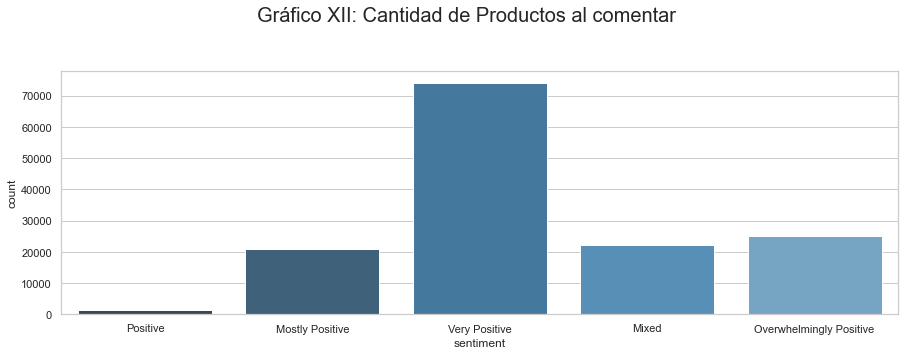

106755 Amazing game, rewarding combo-system and many offline/online-features to keep you playing for long. Never had that much fun in any other fighting game. The only problem in this game: The microphone is always set on, which means, if you forgot to turn off your mic, everyone can hear you even if you don't want to, no options for that in the audio settings. That said, I had to listen to raging guys all over the world, but also to nice ones. :D But you can mute others pressing start on your controller
Oh, and the community is great and helpful! Very Positive


In [80]:
data_nlp=data_nlp[(data_nlp.sentiment=='Positive')|
                        (data_nlp.sentiment=='Mostly Positive')|
                        (data_nlp.sentiment=='Very Positive')|
                        (data_nlp.sentiment=='Mixed')|
                        (data_nlp.sentiment=='Overwhelmingly Positive')]

fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XII: Cantidad de Productos al comentar',fontsize=20, ha='center')
sns.countplot(data_nlp.sentiment)
fig.subplots_adjust(top=0.8)
plt.show()


#breve exploración a través de un ejemplo aleatorio
index_random = np.random.randint(0,high = data_nlp.shape[0])
texto = data_nlp.iloc[index_random].text
print(index_random, texto, data_nlp.iloc[index_random].sentiment)

El Gráfico XII muestra las categorías de comentarios que serán incorporadas a nuestro análisis. 

**Tokenización, StopWords y Rarewords**

In [81]:
import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')


filtrar = []
if True:
    filtrar.append("game")
    filtrar.append("I")
    filtrar.append("The")
    filtrar.append("It")
    filtrar.append("This")
    filtrar.append("one")
    filtrar.append("not")
    filtrar.append("get")
    filtrar.append("really")
    filtrar.append("games")
    filtrar.append("like")
    filtrar.append("play")
    filtrar.append("time")
    filtrar.append("would")
    filtrar.append("even")
    filtrar.append("good")
    filtrar.append("much")
    filtrar.append("You")
    filtrar.append("first")
    filtrar.append("make")
    filtrar.append("playing")
    filtrar.append("If")
    filtrar.append("played")
    filtrar.append("A")
    filtrar.append("There")

#TOKENIZACIÓN CON NLTK
titular_st = nltk.tokenize.sent_tokenize(texto)
titular_wt = nltk.tokenize.word_tokenize(texto)
    
#NORMALIZACIÓN 
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]

titular_wt_sin_sw = [word for word in titular_wt if word not in stopwords]

#FRECUENCIA DE PALABRAS
freq=nltk.FreqDist(titular_wt_sin_sw)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Juani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Textos Positivos

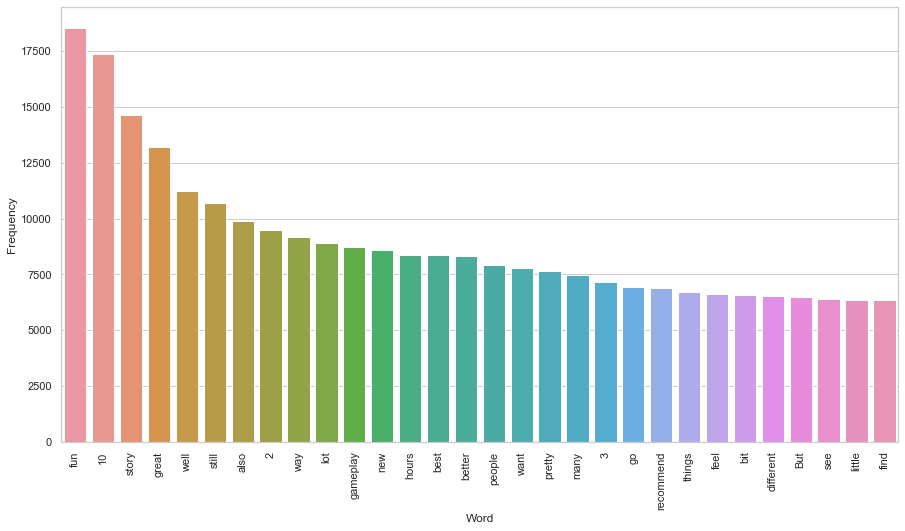

In [82]:
# Agrupar los titulares por tipo. Crear un dataframe para cada uno. Recuerden usar máscaras.
dataset_positive = data_nlp[data_nlp.rating==1]

#toquenización+borrado de stopwords, palabras de filtrar y palabras de menos de tres letras
todos_textos_positivos = []
for i in range(dataset_positive.shape[0]):
    texto = dataset_positive.iloc[i].text
    texto = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(texto)
    texto = [word for word in texto if word not in stopwords]
    texto = [word for word in texto if word not in filtrar]
    textoi= [word for word in texto if len(word)>3]

    todos_textos_positivos.append(texto)
    
todos_textos_positivos = list(itertools.chain(*todos_textos_positivos))
#todos_textos_positivos[0:10]
freq_textos_positivos = nltk.FreqDist(todos_textos_positivos)


df_positivos = pd.DataFrame(list(freq_textos_positivos.items()), columns = ["Word","Frequency"])
df_positivos.sort_values('Frequency',ascending=False, inplace = True)
df_positivos.reset_index(drop = True, inplace=True)
df_positivos.head()

plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_positivos.iloc[:30].Word, y = df_positivos.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Las palabras mas usadas en los textos positivos fueron fun, 10, story.

### Textos Negativos

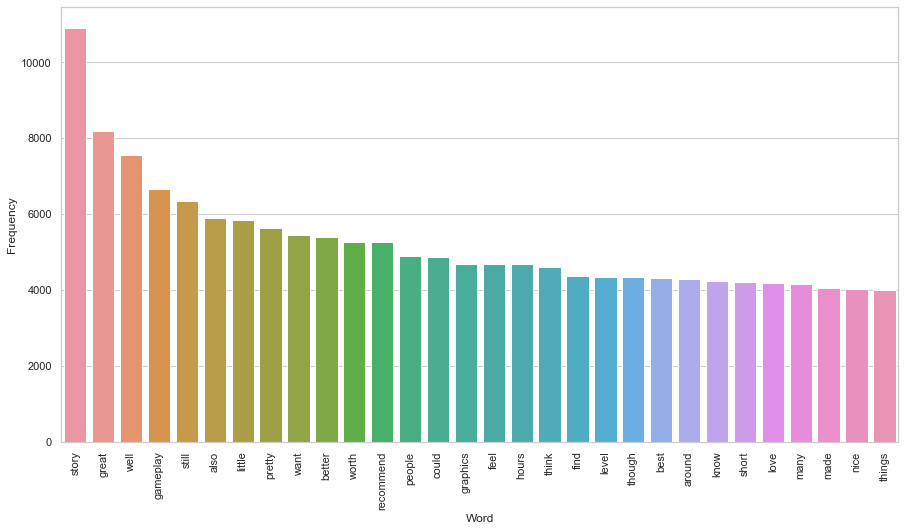

In [83]:
dataset_negative = data_nlp[data_nlp.rating==0]

todos_textos_negativos = []
for i in range(dataset_negative.shape[0]):
    texto = dataset_negative.iloc[i].text
    texto = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(texto)
    texto = [word for word in texto if word not in stopwords]
    texto = [word for word in texto if word not in filtrar]
    texto= [word for word in texto if len(word)>3]
    todos_textos_negativos.append(texto)
    
todos_textos_negativos = list(itertools.chain(*todos_textos_negativos))

freq_negative = nltk.FreqDist(todos_textos_negativos)

df_negative = pd.DataFrame(list(freq_negative.items()), columns = ["Word","Frequency"])

df_negative.sort_values('Frequency',ascending=False, inplace = True)

df_negative.reset_index(drop = True, inplace=True)

plt.figure(figsize = ( 15,8))
plot = sns.barplot(x  = df_negative.iloc[:30].Word, y = df_negative.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

Las palabras que mas frecuencia tienen no parecen coincidir o tener coherencia con algo negativo (story,great,well)

**Lematización**

In [84]:
dataset= pd.concat([dataset_positive, dataset_negative])
dataset=pd.concat([dataset.text,dataset.rating],axis=1)
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [85]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [86]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')
#stopword.remove('no')
#stopword.remove('not')

In [87]:
%%time
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

titular_list=[]
for titular in dataset.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    # Eliminamos las palabras demenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Wall time: 1h 34min 52s


In [88]:
dataset["titular_lemm"] = titular_list
dataset_lemm = pd.concat([dataset.titular_lemm,dataset.rating],axis=1)
dataset_lemm.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_lemm.head()

,titular_lemm,rating
product_id,,
631920,somewhere zibylon zibylon command centre read ...,1
631920,cute little game puzzles actually quite though...,1
482440,essence remember place looks absolutely beauti...,1
493540,figment mind important functions individual ev...,1
341980,dont even know start game build based good ide...,1


In [89]:
# Tomamso la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_titulos = list(dataset_lemm['titular_lemm'].values)
recomendado = dataset_lemm['rating'].values

## Para probar con Stemmizer:
#list_titulos = list(dataset_stem'titular_stem'].values)
#is_sarc = dataset_stem['is_sarcastic'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_titulos = cou_vec.fit_transform(list_titulos)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abilities', 'ability', 'able', 'absolutely', 'access', 'achievement', 'achievements', 'across', 'acting', 'action', 'actions', 'actual', 'actually', 'added', 'addicting', 'addictive', 'adding', 'addition', 'adds', 'adventure', 'ahead', 'alien', 'allow', 'allows', 'almost', 'alone', 'along', 'alot', 'alpha', 'already', 'alright', 'also', 'although', 'always', 'amazing', 'ammo', 'amount', 'animation', 'animations', 'anime', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'anyway', 'apart', 'arcade', 'area', 'areas']


acc :  0.5188403781979978


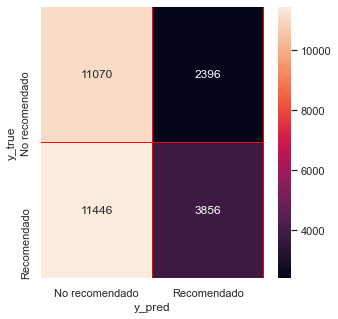

In [90]:
x = matriz_titulos.toarray()
y = recomendado

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)


from sklearn.metrics import confusion_matrix

def confusion(ytest,y_pred):
    names=["No recomendado","Recomendado"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return


from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))


y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

acc:  0.5784899888765295


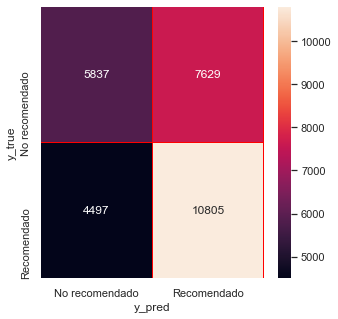

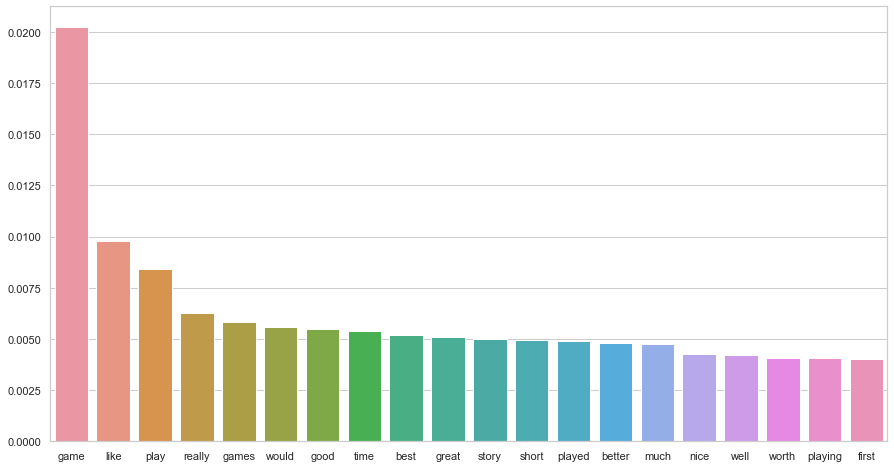

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 100, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))


y_pred=rf.predict(xtest)
confusion(ytest,y_pred)


# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

##  Conclusion NLP

**Como dijimos al principio, tratamos de incorporar los comentarios al sistema de recomendacion, sin embargo al terminar el modelo, nos damos cuenta que no es factible de poner en practica ya que no mejora los sistemas antes propuestos. Esto se puede dar ya que no existen correlaciones entre las palabras mas repetidas en comentasrios negativos y postitivos con lo que realmente son, por lo tanto no hay una coherencia estricta. Ademas si obsevamos este mismo tema, comparten entre ellas varias palabras. Existe un fuerte desbalance en la columna sentiments tambien por lo que esto tambien nos juega en contra a la hora del desarrollo del modelo. No recomiendo trabajar con este modelo.**

## Conclusion general

**Al analizar todos los modelos y los cambios realizados en este ultimo proyecto, creo que fue una buena decision cambiar la variable ranking tomando como punto de partida una medida mas acertada o creible que es la mediana y asi separar el ranking simplemente en si le gusto o no. Por una parte simplifica el dataset y si nos fijamos en los resultados obtenidos podemos ver que, si comparamos el RMSE del modelo del proyecto 3 tenia un error de 2.44 y al estar en la misma unidad que la variable, en ese caso de 0 a 10 y nosotros apuntabamos a un puntaje por encima de 7, no era bueno prediciendo los juegos que realmente le gustaban.
En cambio en este modelo si bien el error es de 0.469 eso es para una variable binaria lo cual quiere decir que es mas preciso porque tiene menos probabilidad de fracaso en los casos positivos que en el modelo del proyecto 3.**

##### Juan Ignacio Quinteros